# Анализ данных в задаче кредитного скоринга
* LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
* SEX: пол клиента (1 = мужской, 2 = женский )
* EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
* MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
* AGE: возраст в годах
* PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
* BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
* PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
* default - индикатор невозврата денежных средств

In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline
matplotlib.rc('patch', force_edgecolor=True)

In [2]:
df = pd.read_csv('credit_card_default_analysis.csv')

In [3]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


# Задание 1
Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

In [4]:
def get_data(feature, default):
    return df.loc[df.default == default, feature].values

def hist(feature, default, normalize=False, **kwargs):
    data = get_data(feature, default)
    label = 'not default'
    color = 'green'
    weights = np.ones_like(data, dtype='float64')
    if default:
        label = 'default'
        color = 'red'
    if normalize:
        weights /= len(data)
    plt.hist(data, color=color, label=label, weights=weights, **kwargs)
    plt.legend()

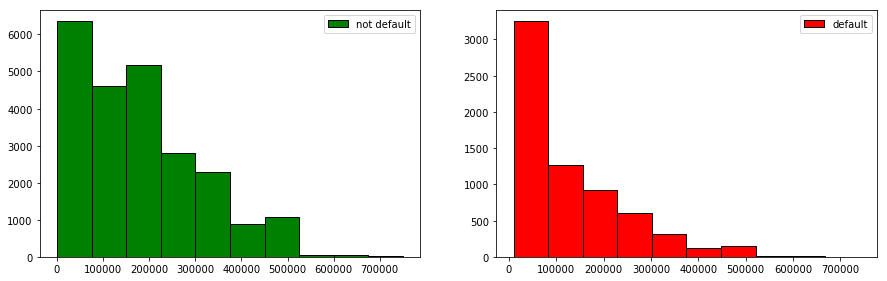

In [5]:
plt.figure(figsize=(15, 10))

plt.subplot(221)
hist('LIMIT_BAL', 0, range=(0, 750000));
plt.subplot(222)
hist('LIMIT_BAL', 1);

На гистограммах видно, что распределение людей, не вернувших кредит смещено в сторону небольших значений кредитного лимита. Проверим это строго: построим с помощью бутстрепа 95% доверительный интервал для медиан кредитного лимита в двух группах, а также построим доверительный интервал для разности медиан.

In [6]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [7]:
default_lim_median_scores = np.median(get_bootstrap_samples(get_data('LIMIT_BAL', 1), 1000),
                                      axis=1)
nondefault_lim_median_scores = np.median(get_bootstrap_samples(get_data('LIMIT_BAL', 0), 1000),
                                         axis=1)
diff_lim_median_scores = nondefault_lim_median_scores - default_lim_median_scores

In [8]:
print("Доверительный интервал для медианы лимитов людей не вернувших кредит: [%i, %i]" \
      % tuple(stat_intervals(default_lim_median_scores, 0.05)))
print("Доверительный интервал для медианы лимитов людей вернувших кредит: [%i, %i]" \
      % tuple(stat_intervals(nondefault_lim_median_scores, 0.05)))
print("Доверительный интервал для разности медиан: [%i, %i]" \
      % tuple(stat_intervals(diff_lim_median_scores, 0.05)))

Доверительный интервал для медианы лимитов людей не вернувших кредит: [80000, 90000]
Доверительный интервал для медианы лимитов людей вернувших кредит: [150000, 150000]
Доверительный интервал для разности медиан: [60000, 70000]


Видим, что доверительные интервалы для 2х групп не пересекаются и доверительный интервал для разности медиан не содержит нуль, поэтому можно сделать вывод, что медианы в 2х группах различаются статистически значимо. Кроме этого разность медиан составляет 60000 - 70000, что является достаточно большим значением по сравнению со значением медианы в группе людей, которые не вернули кредит. Поэтому различие медиан в 2х группах является также и практически значимым.

Проверим также гипотезу о равенстве распеделений с помощью критерия Манна-Уитни против двустронней альтернативы с уровнем значимости 0.05.

In [9]:
from scipy.stats import mannwhitneyu

In [10]:
mannwhitneyu(get_data('LIMIT_BAL', 0), get_data('LIMIT_BAL', 1), alternative='two-sided')

MannwhitneyuResult(statistic=95786286.5, pvalue=1.2255485818223303e-189)

Достигаемый уровень значимости крайне мал, поэтому мы с уверенностью отвергаем нулевую гипотезу, тем самым подтверждая ранее полученный результат.

# Задание 2
Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

In [11]:
df.SEX -= 1 # Сделаем значения признака SEX бинарными (0 - мужской и 1 - женский)

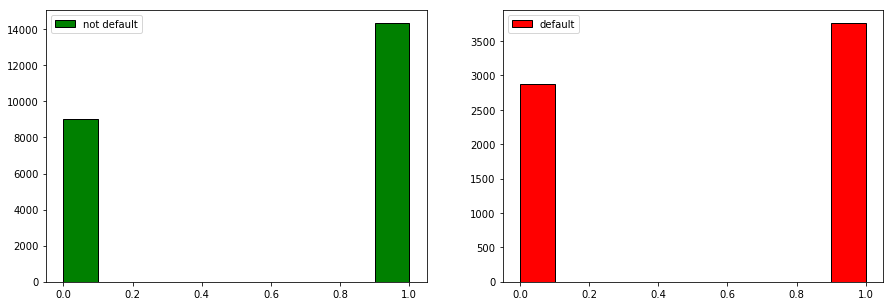

In [12]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
hist('SEX', 0)
plt.subplot(122)
hist('SEX', 1)

Из графиков кажется, что доля женщин среди людей, вернувших кредит немного больше, чем среди не вернувших кредит. Проверим это построив 95% доверительный интервал для разности долей женщин.

In [13]:
from scipy.stats import norm

def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [14]:
print('Точечная оценка доли женщин вернувших кредит: ', get_data('SEX', 0).mean())
print('Точечная оценка доли женщин не вернувших кредит: ', get_data('SEX', 1).mean())

Точечная оценка доли женщин вернувших кредит:  0.614149974319
Точечная оценка доли женщин не вернувших кредит:  0.567058468957


In [15]:
print('Доверительный интервал для разности долей женщин в 2х группах: [%.4f, %.4f]' % \
     proportions_confint_diff_ind(get_data('SEX', 0), get_data('SEX', 1)))

Доверительный интервал для разности долей женщин в 2х группах: [0.0336, 0.0605]


Видно, что доверительный интервал для разности долей не содержит нуль, поэтому разница является статистически значимой.

Проверим также статистическую значимость с помощью z-критерия для долей в независимых выборках. Проверять будем против двусторонней альтернативы с уровнем значимости 0.05.

In [16]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - norm.cdf(z_stat)
    
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [17]:
proportions_diff_z_test(proportions_diff_z_stat_ind(get_data('SEX', 0), get_data('SEX', 1)),
                        alternative='two-sided')

4.4728665216098307e-12

Достигаемый уровень значимости оказался очень близким к нулю, что позволяет нам с уверенностью отвергнуть нулевую гипотезу о равенстве долей в этих группах.

В то же время, доля женщин вернувших кредит отличается на 3-6%, что вряд ли является практически значимым отличием. Скорее всего существуют более информативные и практически значимые признаки, на которые стоит обратить внимание. Хотя конечное решение о практической значимости этого признака зависит от того, на сколько консервативную политику проводит банк.

# Задание 3
Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?


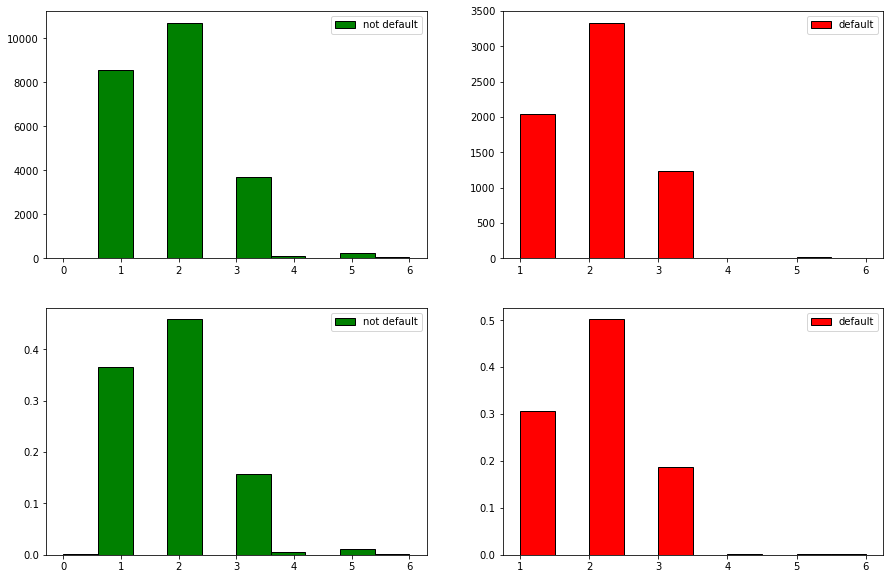

In [18]:
plt.figure(figsize=(15, 10))

plt.subplot(221)
hist('EDUCATION', 0)
plt.subplot(222)
hist('EDUCATION', 1)

plt.subplot(223)
hist('EDUCATION', 0, normalize=True)
plt.subplot(224)
hist('EDUCATION', 1, normalize=True)

Из графиков видно, что магистров больше среди людей вернувших кредит (по сравнению с долей магистров которые не вернули кредит). А вот выпускников школы чуть больше среди людей которые не вернули кредит. 

Для начала проверим гипотезу о том, что образование не влияет на то, вернёт ли человек долг против общей альтернативы. Для этого будем использовать критерий хи-квадрат.

In [19]:
from scipy.stats import chi2_contingency

In [20]:
edu_cross_tab = pd.crosstab(df.EDUCATION, df.default)
edu_cross_tab

default,0,1
EDUCATION,,
0,14,0
1,8549,2036
2,10700,3330
3,3680,1237
4,116,7
5,262,18
6,43,8


In [21]:
_, p, _, exp_freq = chi2_contingency(edu_cross_tab, correction=False)
print('Доля элементов с ожидаемым значением >= 5: %.3f' % (exp_freq >= 5).mean())
print('Достигаемый уровень значимости: ', p)

Доля элементов с ожидаемым значением >= 5: 0.929
Достигаемый уровень значимости:  1.23326262454e-32


Видим, что доля элементов с ожидаемым значением >= 5 больше чем 80%, а значит, критерий хи-квадрат в данном случае можно применять. Достигаемый уровень значимости значительно меньше чем 0.05, а значит нулевую гипотезу мы уверенно отвергаем.

Теперь составим таблицу сопряженности для разности ожидаемых и наблюдаемых значений числа людей вернувших и не вернувших долг и нормируем её: поделим каждый элемент таблицы на соответствующую величину ожидаемого значения. Таким образом получим таблицу с относительными отклонениями наблюдаемых значений от ожидаемых.

In [22]:
col_sum = np.array([np.sum(df.EDUCATION == i) for i in range(7)]).reshape((7, 1))
row_sum = np.array([np.sum(df.default == i) for i in range(2)]).reshape((1, 2))
expected_values = col_sum.dot(row_sum) / len(df)

In [23]:
1 - edu_cross_tab / expected_values

default,0,1
EDUCATION,,
0,-0.284027,1.000000
1,-0.037047,0.130436
2,0.020735,-0.073004
3,0.039004,-0.137324
4,-0.210952,0.742719
5,-0.201482,0.709377
6,-0.082611,0.290856


Судя по таблице люди с докторской степенью (0-я строка), люди с начальным образованием (4 строка) и с прочим образованием (5 строка) лучше всех отдают долг, однако доля таких людей в нашей выборке очень мала. Если смотреть только на 3 самые многочисленные группы (которые составляют 98.5% от нашей выборки): магистрантов, бакалавров и выпускников школ, то лучше всех отдают долг магистранты (1 строка), а хуже всех отдают долг выпускники школы (3 строка).

Построим доверительные интервалы для разницы долей магистрантов и выпускников школ:

In [24]:
edu_nondefault, edu_default = get_data('EDUCATION', 0), get_data('EDUCATION', 1)

In [25]:
print('Разница долей магистрантов в 2х группах: [%.4f, %.4f]:' % \
      proportions_confint_diff_ind(edu_nondefault == 1, edu_default == 1))
print('Разница долей выпускников школ в 2х группах: [%.4f, %.4f]:' % \
      proportions_confint_diff_ind(edu_nondefault == 3, edu_default == 3))

Разница долей магистрантов в 2х группах: [0.0464, 0.0718]:
Разница долей выпускников школ в 2х группах: [-0.0394, -0.0184]:


Также как и в предыдущем задании, нельзя сказать явно, что различие долей является практически значимым.

# Задание 4
Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

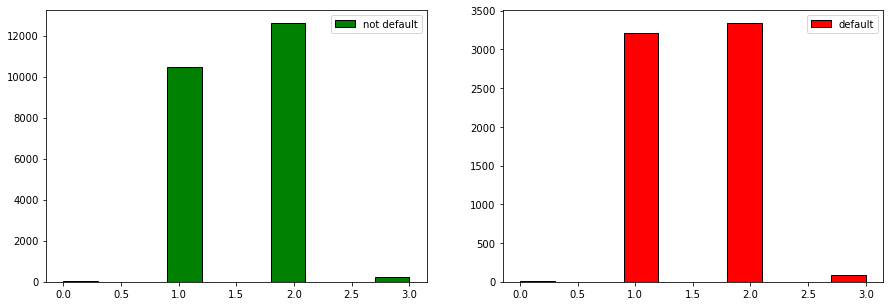

In [26]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
hist('MARRIAGE', 0)
plt.subplot(122)
hist('MARRIAGE', 1)

На графиках видно, что женатых людей больше среди тех, кто не отдал долг, чем среди тех, кто долг отдал. Для того, чтобы это проверить будем использовать коэффицент Крамера.

In [27]:
marr_crosstab = pd.crosstab(df.MARRIAGE, df.default)
marr_crosstab

default,0,1
MARRIAGE,,
0,49,5
1,10453,3206
2,12623,3341
3,239,84


In [28]:
chi2, p, _, exp_freq = chi2_contingency(marr_crosstab, correction=False)
print('Доля элементов с ожидаемым значением >= 5: %.3f' % (exp_freq >= 5).mean())
print('Коэффицент Крамера: ', np.sqrt(chi2 / len(df)))
print('Достигаемый уровень значимости: ', p)

Доля элементов с ожидаемым значением >= 5: 1.000
Коэффицент Крамера:  0.0344782036628
Достигаемый уровень значимости:  8.82586245758e-08


Т.к. доля элементов с ожидаемым значением >= 5 больше чем 80%, и достигаемый уровень значимости значительно меньше чем 0.05, то зависимоть выплаты долга от семейного статуса статистически значима. Однако значение корреляции очень небольшое, поэтому вряд ли оно имеет практическую значимость.

# Задание 5
Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

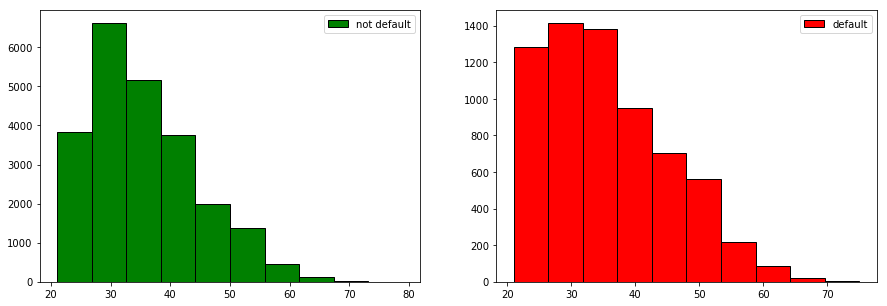

In [29]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
hist('AGE', 0)
plt.subplot(122)
hist('AGE', 1)

По графикам кажется, что распределение возрастов в 2х группах различается. Будем решать это задание аналогично [Заданию 1](#Задание-1).

In [30]:
default_age_median_scores = np.median(get_bootstrap_samples(get_data('AGE', 1), 1000),
                                      axis=1)
nondefault_age_median_scores = np.median(get_bootstrap_samples(get_data('AGE', 0), 1000),
                                         axis=1)
diff_age_median_scores = default_age_median_scores - nondefault_age_median_scores

In [31]:
print("Доверительный интервал для медианы возрастов людей не вернувших кредит: [%i, %i]" \
      % tuple(stat_intervals(default_age_median_scores, 0.05)))
print("Доверительный интервал для медианы возрастов людей вернувших кредит: [%i, %i]" \
      % tuple(stat_intervals(nondefault_age_median_scores, 0.05)))
print("Доверительный интервал для разности медиан возрастов: [%i, %i]" \
      % tuple(stat_intervals(diff_age_median_scores, 0.05)))

Доверительный интервал для медианы возрастов людей не вернувших кредит: [34, 35]
Доверительный интервал для медианы возрастов людей вернувших кредит: [34, 34]
Доверительный интервал для разности медиан возрастов: [0, 1]


Видим, что доверительные интервалы для 2х групп пересекаются, а доверительный интервал для разности медиан содержит нуль, поэтому мы не можем сказать, что медианы статистически значимо различаются.

Проверим гипотезу о равенстве распеделений с помощью критерия Манна-Уитни против двустронней альтернативы с уровнем значимости 0.05.

In [32]:
mannwhitneyu(get_data('AGE', 0), get_data('AGE', 1), alternative='two-sided')

MannwhitneyuResult(statistic=76966879.5, pvalue=0.37250354348986159)

Достигаемый уровень значимости существенно выше чем 0.05, а значит мы не можем отвергнуть нулевую гипотезу о равенстве распределений.